In [8]:
%load_ext autoreload

In [9]:
%autoreload 2

In [17]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, StratifiedShuffleSplit
from sklearn.metrics import average_precision_score, roc_auc_score
import numpy as np
from sklearn import tree
from deslib.des.knora_e import KNORAE
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
import torch
from time import time
from skopt import gp_minimize
from skopt.space import Integer, Real
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import average_precision_score
from sklearn.model_selection import RandomizedSearchCV

In [336]:
chembl = pd.read_csv('/home/dionizije/Documents/drug_attrition_oracle/data/chembl_4_smiles.csv', index_col=0)

In [40]:
chembl.loc[chembl['smiles'].str.contains('\.')]

,chembl_id,pubchem_cid,smiles,parent_smiles,chembl_tox,withdrawn
464,CHEMBL1237066,62859,O=C([O-])C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)...,O=C([O-])C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)...,Safe,0
700,CHEMBL2010412,452192,C[n+]1c2cc(N)ccc2cc2ccc(N)cc21.Nc1ccc2cc3ccc(N...,missing,Safe,0
842,CHEMBL1200747,62358,CC(O)C(=O)O.N,CC(O)C(=O)O.N,Safe,0
1376,CHEMBL2106975,61102,O=C([O-])O.[K+],O=C([O-])O.[K+],Safe,0
1409,CHEMBL1255943,2723891,Cl.N[C@@H](CCC(=O)O)C(=O)O,Cl.N[C@@H](CCC(=O)O)C(=O)O,Safe,0
...,...,...,...,...,...,...
10391,CHEMBL1200691,8896,CC(=O)[O-].CC(=O)[O-].[Mg+2],CC(=O)[O-].CC(=O)[O-].[Mg+2],Safe,0
10524,CHEMBL2106123,13136,O=C([O-])CC(O)(CC(=O)[O-])C(=O)[O-].O=C([O-])C...,O=C([O-])CC(O)(CC(=O)[O-])C(=O)[O-].O=C([O-])C...,Safe,0
10531,CHEMBL2364968,90661668,CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...,missing,Safe,0
10560,CHEMBL261772,missing,C=C1c2c(Cl)ccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(...,C=C1c2c(Cl)ccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(...,Safe,0


In [338]:
chembl['smiles'].str.unique()

AttributeError: 'StringMethods' object has no attribute 'unique'

# Models

In [125]:
search_space = { # values for boostrap can be either True or False # values of max_depth are integers from 6 to 20
        "max_iter": Integer(10, 1000),
        "learning_rate": Real(0.001, 1),  
        "min_samples_leaf": Integer(1, 30)
    }

In [119]:
forest_clf = HistGradientBoostingClassifier(early_stopping=True, validation_fraction=0.15)

In [126]:
forest_bayes_search = BayesSearchCV(forest_clf, search_space, n_iter=32, # specify how many iterations
                                    scoring="roc_auc", n_jobs=-1, cv=5)

In [127]:
forest_bayes_search.fit(X, y)

BayesSearchCV(cv=5,
              estimator=HistGradientBoostingClassifier(early_stopping=True,
                                                       validation_fraction=0.15),
              n_iter=32, n_jobs=-1, scoring='roc_auc',
              search_spaces={'learning_rate': Real(low=0.001, high=1, prior='uniform', transform='identity'),
                             'max_iter': Integer(low=10, high=1000, prior='uniform', transform='identity'),
                             'min_samples_leaf': Integer(low=1, high=30, prior='uniform', transform='identity')})

In [128]:
forest_bayes_search.best_estimator_

HistGradientBoostingClassifier(early_stopping=True,
                               learning_rate=0.01619991660275452, max_iter=25,
                               min_samples_leaf=12, validation_fraction=0.15)

# AP

In [129]:
forest_bayes_search.best_score_

0.6878546912287747

# ROC auc

In [104]:
forest_bayes_search.best_score_

0.6895023895534506

In [79]:
aps = []
aucs = []
for train_index, test_index in skf.split(X, y):
    scaler = StandardScaler()
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    clf.fit(X_train, y_train)
    #knorae = KNORAE(pool_classifiers)
    #knorae.fit()
    log_probs = clf.predict_proba(X_test)[:, 1]
    ap = average_precision_score(y_test, log_probs)
    roc_auc = roc_auc_score(y_test, log_probs)
    aps.append(ap)
    aucs.append(roc_auc)

In [85]:
np.mean(aps)

0.14099473491817066

In [87]:
np.mean(aucs)

0.6449456398734204

# Knora

In [107]:
aps = []
aucs = []
for train_index, test_index in skf.split(X, y):
    scaler = StandardScaler()
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train, X_dsel, y_train, y_dsel = train_test_split(X_train, y_train, test_size=0.5)
    
    clf = forest_bayes_search.best_estimator_
    clf.fit(X_train, y_train)
    knorae = KNORAE(clf)
    knorae.fit(X_dsel, y_dsel)
    
    log_probs = clf.predict_proba(X_test)[:, 1]
    ap = average_precision_score(y_test, log_probs)
    roc_auc = roc_auc_score(y_test, log_probs)
    aps.append(ap)
    aucs.append(roc_auc)

In [110]:
np.mean(aps)

0.1549412394889774

In [111]:
np.mean(aucs)

0.6263718833458845

## Complementary models

In [114]:
from dao import DrugAttritionOracle
import pickle
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from utils.metrics import table_metrics_trees
from sklearn.metrics import confusion_matrix
import shap

In [428]:
train = pd.read_csv('../data/processing_pipeline/TDC_predictions/train_subtasks_predictions.csv', index_col=0)
test = pd.read_csv('../data/processing_pipeline/TDC_predictions/test_subtasks_predictions.csv', index_col=0)
file = open('../production/complementary_model/random_forest_classifier.pkl', 'rb')
y_train = train['wd_consensus_1']
y_test = test['wd_consensus_1']
X_train = train.drop(columns=['chembl_id', 'standardized_smiles', 'wd_consensus_1'])
X_test = test.drop(columns=['chembl_id', 'standardized_smiles', 'wd_consensus_1'])
rf = pickle.load(file)
node_feat_importance = pd.DataFrame(data=rf.feature_importances_[np.newaxis], columns=X_train.columns, index=[0])
#feats = list(node_feat_importance.transpose().sort_values(0, ascending=False)[:13].index)

## Run on subset

# XGBoost

In [441]:
params = {
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight' : [ 1, 3, 5, 7 ],
 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ],
 'scale_pos_weight': [5, 10, 15, 20, 35],
}

In [442]:
import xgboost
classifier = xgboost.XGBClassifier()

In [443]:
rs_model=RandomizedSearchCV(clbassifier,param_distributions=params,n_iter=50,scoring='average_precision',n_jobs=-1,cv=5,verbose=3)

In [567]:
rs_model.best_params_

{'scale_pos_weight': 10,
 'min_child_weight': 5,
 'max_depth': 15,
 'learning_rate': 0.05,
 'gamma': 0.2,
 'colsample_bytree': 0.5}

In [580]:
classifier = xgboost.XGBClassifier(learning_rate=rs_model.best_params_['learning_rate'])

In [581]:
classifier.fit(X_train, y_train)

[15:59:12] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [584]:
classifier.get_booster().best_ntree_limit

100

In [444]:
rs_model.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  6.3min finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:43:15] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                   

In [562]:
X_test

,CYP2C9_Substrate_CarbonMangels,CYP2D6_Substrate_CarbonMangels,sr-are,CYP3A4_Veith,nr-er-lbd,nr-er,Solubility_AqSolDB,sr-atad5,Caco2_Wang,CYP2D6_Veith,...,CYP2C9_Veith,CYP1A2_Veith,HIA_Hou,nr-ppar-gamma,Clearance_Hepatocyte_AZ,Carcinogens_Languin,nr-aromatase,sr-mmp,sr-p53,predict_withdrawn
0,0.069458,0.004521,0.506577,0.224221,0.075100,0.000071,-2.688965,0.013394,-5.617864,0.001843,...,0.036047,0.006817,0.013520,0.008847,35.181927,0.286017,0.001043,2.742608e-06,0.009950,0.470054
1,0.103099,0.232109,0.827061,0.226972,0.403773,0.932831,-5.085590,0.917336,-4.535133,0.156842,...,0.782207,0.921282,0.998295,0.011342,75.808525,0.374289,0.004148,9.678469e-01,0.909958,0.606440
2,0.340530,0.142519,0.457970,0.958183,0.235134,0.000681,-3.813414,0.002442,-4.795193,0.151132,...,0.874266,0.762396,0.996635,0.769668,33.605370,0.310629,0.000067,1.533354e-01,0.012377,0.485826
3,0.025499,0.010939,0.081060,0.343454,0.095015,0.014898,-3.072849,0.001167,-3.959646,0.000006,...,0.322632,0.068863,0.991903,0.148467,113.047005,0.615662,0.000727,5.591495e-04,0.049619,0.129884
4,0.417281,0.264848,0.112804,0.030651,0.802562,0.937043,-5.873740,0.248247,-3.773222,0.007486,...,0.841268,0.853914,0.999501,0.001056,74.288340,0.583670,0.002604,1.606945e-01,0.145084,0.681620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,0.458754,0.308566,0.111702,0.000344,0.003962,0.715382,-0.882686,0.000556,-4.659957,0.000003,...,0.109648,0.207328,0.873437,0.005758,32.886288,0.352992,0.000028,6.340616e-07,0.007156,0.449080
391,0.167058,0.508774,0.665901,0.023806,0.548024,0.058295,-1.635835,0.725651,-5.748230,0.772372,...,0.330940,0.088069,0.997442,0.000385,69.781120,0.486183,0.000086,2.883503e-02,0.026883,0.631011
392,0.115259,0.038823,0.233657,0.000564,0.361210,0.060816,-3.895102,0.067972,-4.211524,0.011219,...,0.393423,0.027980,0.996202,0.000975,1.042210,0.252291,0.000168,1.127547e-03,0.001459,0.668740
393,0.234541,0.107649,0.050168,0.015203,0.033033,0.000702,-1.089897,0.025235,-4.674285,0.002292,...,0.365868,0.016981,0.859953,0.000113,8.636477,0.658230,0.000151,4.709835e-07,0.031638,0.381551


In [565]:
#optimal threshold F1 withdrawn class random forest
optimal_f1_score = []
optimal_threshold = []
for threshold in np.arange(0, 1, 0.01):
    predictions_df = train_pred_df.copy()
    predictions_df['predicted_class'] = 0
    predictions_df.loc[predictions_df['probabilities'] > threshold, 'predicted_class'] = 1
    optimal_f1_score.append(f1_score(
        predictions_df['target'], predictions_df['predicted_class'], average='binary'
    ))
    optimal_threshold.append(threshold)

optimal_f1_index = np.argmax(np.array(optimal_f1_score))
optimal_threshold = optimal_threshold[optimal_f1_index]

test_pred_df = pd.DataFrame({'probabilities': predictions[:, 1],
                            'wd_consensus_1': y_test,
                            
                             'predicted_class': rs_model.best_estimator_.predict(X_test)})
results = table_metrics_trees(test_pred_df, 'wd_consensus_1')

In [566]:
results

,AP withdrawn,AP approved,AUROC withdrawn,Balanced accuracy,Precision withdrawn,Recall withdrawn,Precision approved,Recall approved,True positives,True negatives,False positives,False negatives
0,0.397815,0.790555,0.832989,0.629392,0.5,0.292683,0.921833,0.966102,12,342,12,29


## Shap Graphs

In [18]:
from utils.metrics import table_metrics_trees
import shap

In [19]:
train = pd.read_csv('/home/dionizije/Documents/drug_attrition_oracle/data/processing_pipeline/TDC_predictions/train_subtasks_predictions.csv', index_col=0)
test = pd.read_csv('/home/dionizije/Documents/drug_attrition_oracle/data/processing_pipeline/TDC_predictions/test_subtasks_predictions.csv', index_col=0)

In [20]:
classifier = XGBClassifier(learning_rate=0.1,
        max_depth=3,
        min_child_weight=3,
        gamma=0.2,
        colsample_bytree=0.4,
        scale_pos_weight=10,
        n_estimators=200)

In [21]:
withdrawn_col = 'wd_consensus_1'

In [22]:
y_train = train[withdrawn_col]
y_test = test[withdrawn_col]
X_train = train.drop(columns=['chembl_id', 'standardized_smiles', withdrawn_col])
X_test = test.drop(columns=['chembl_id', 'standardized_smiles', withdrawn_col])

In [23]:
classifier.fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[10:17:10] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [178]:
explainer = shap.TreeExplainer(classifier)
shap_values = explainer(X_test)

In [32]:
predictions = classifier.predict_proba(X_test, ntree_limit=classifier.get_booster().best_ntree_limit)
test_pred_df = pd.DataFrame({'probabilities': predictions[:, 1],
                             withdrawn_col: y_test,
                             'predicted_class': classifier.predict(X_test, ntree_limit=classifier.get_booster().best_ntree_limit)})

In [33]:
results = table_metrics_trees(test_pred_df, withdrawn_col)

In [34]:
results

,F1 score,AP withdrawn,AP approved,AUROC withdrawn,Balanced accuracy,Precision withdrawn,Recall withdrawn,Precision approved,Recall approved,True positives,True negatives,False positives,False negatives
0,0.488889,0.389249,0.794605,0.806394,0.730157,0.44898,0.536585,0.945087,0.923729,22,327,27,19


In [46]:
pd.DataFrame(X_test.iloc[0]).transpose()

,CYP2C9_Substrate_CarbonMangels,CYP2D6_Substrate_CarbonMangels,sr-are,CYP3A4_Veith,nr-er-lbd,nr-er,Solubility_AqSolDB,sr-atad5,Caco2_Wang,CYP2D6_Veith,...,CYP2C9_Veith,CYP1A2_Veith,HIA_Hou,nr-ppar-gamma,Clearance_Hepatocyte_AZ,Carcinogens_Languin,nr-aromatase,sr-mmp,sr-p53,predict_withdrawn
0,0.069458,0.004521,0.506577,0.224221,0.0751,0.000071,-2.688965,0.013394,-5.617864,0.001843,...,0.036047,0.006817,0.01352,0.008847,35.181927,0.286017,0.001043,0.000003,0.00995,0.470054


In [47]:
shap_values = explainer(pd.DataFrame(X_test.iloc[0]).transpose())

AttributeError: 'Tree' object has no attribute 'base'

In [48]:
shap_values

.values =
array([[ 0.14079896, -0.03406885, -0.1329313 , -0.08487384, -0.03467364,
        -0.37373567,  0.05098419,  0.1273895 ,  0.16156864,  0.00224801,
         0.09745535, -0.30472565,  0.01515849, -0.02832849,  0.03659619,
        -0.02044659, -0.18599467, -0.20645829,  0.06023289,  0.30288374,
        -0.31204173,  0.03588797,  0.02517371, -0.3674089 , -0.11305201,
        -0.0098564 , -0.02889552, -0.01797869, -0.00969102,  0.08541779,
        -0.02005842, -0.30482754, -0.28543657,  0.04716998, -0.03427696,
         0.00729414, -0.33696723, -0.17669038, -0.00174403]],
      dtype=float32)

.base_values =
array([0.14568608], dtype=float32)

.data =
array([[ 6.94579000e-02,  4.52056100e-03,  5.06576540e-01,
         2.24221140e-01,  7.51004740e-02,  7.07113200e-05,
        -2.68896500e+00,  1.33937190e-02, -5.61786370e+00,
         1.84287150e-03,  3.97796400e-01,  7.40116500e+01,
         2.41917650e-01,  9.87183600e-03,  5.11555300e-06,
         1.10429930e+00,  2.46580660e-01,

In [54]:
import seaborn as sns

In [72]:
shap_values.values[:, :5]

array([[ 0.14079896, -0.03406885, -0.1329313 , -0.08487384, -0.03467364]],
      dtype=float32)

In [223]:
plot_values = pd.DataFrame(columns=X_test.columns[:5], data=shap_values.values[:, :5]).transpose().reset_index()
plot_values

,index,0,1,2,3,4,5,6,7,8,...,385,386,387,388,389,390,391,392,393,394
0,CYP2C9_Substrate_CarbonMangels,0.140799,-0.046508,-0.146208,0.228336,-0.283075,-0.097380,-0.170055,-0.258452,0.174209,...,-0.012623,-0.064978,-0.108662,0.264944,-0.092699,-0.312441,-0.047134,-0.027074,0.013138,0.045320
1,CYP2D6_Substrate_CarbonMangels,-0.034069,0.016314,0.007724,-0.005670,0.025394,-0.004332,0.002849,0.005850,-0.012732,...,0.002480,-0.017593,0.016510,0.009448,0.015386,0.002336,0.014277,-0.038484,-0.002960,0.004089
2,sr-are,-0.132931,-0.118610,-0.165350,0.065518,-0.079473,-0.085480,-0.019242,-0.045149,-0.071835,...,0.073621,-0.085613,-0.068513,-0.106870,-0.045186,-0.090290,-0.000400,-0.130050,0.162986,0.273678
3,CYP3A4_Veith,-0.084874,-0.025734,0.124890,-0.024047,-0.058583,-0.065799,-0.101873,-0.074767,-0.032110,...,-0.112895,-0.046872,0.008964,0.030448,-0.030846,0.047032,-0.046983,0.034936,-0.023365,-0.039875
4,nr-er-lbd,-0.034674,0.020215,0.001993,-0.067147,0.016179,0.056575,0.006169,-0.087414,0.048805,...,-0.055399,-0.038269,0.054525,-0.047861,-0.036698,-0.161187,0.036251,0.015349,-0.027335,-0.002174


In [ ]:
plo

In [100]:
series = plot_values[0]
color = (series > 0).apply(lambda x: [225, 42, 42] if x else [0, 128, 55])

In [ ]:
px = 1 / plt.rcParams['figure.dpi']
fig, ax = plt.subplots(figsize=(300*px, 500*px))
ax = sns.barplot(data=plot_values, x=0, y='index')
ax.set_xlabel("SHAP value")
ax.set_ylabel("")

for rect in ax.patches:
    if rect.get_width() < 0:
        rect.set_color("#1E90FF") 
    else:
        rect.set_color("#DC143C")
ax.set_box_aspect(3/len(ax.patches))

In [326]:
plt.bar_label(ax.containers[0], size=16)

AttributeError: module 'matplotlib.pyplot' has no attribute 'bar_label'

In [176]:
shap_values[0].values

array([ 0.14079896, -0.03406885, -0.1329313 , -0.08487384, -0.03467364,
       -0.37373567,  0.05098419,  0.1273895 ,  0.16156864,  0.00224801,
        0.09745535, -0.30472565,  0.01515849, -0.02832849,  0.03659619,
       -0.02044659, -0.18599467, -0.20645829,  0.06023289,  0.30288374,
       -0.31204173,  0.03588797,  0.02517371, -0.3674089 , -0.11305201,
       -0.0098564 , -0.02889552, -0.01797869, -0.00969102,  0.08541779,
       -0.02005842, -0.30482754, -0.28543657,  0.04716998, -0.03427696,
        0.00729414, -0.33696723, -0.17669038, -0.00174403], dtype=float32)

In [1]:
from tdc.single_pred import ADME

In [24]:
data = ADME(name = 'Bioavailability_Ma')

Found local copy...
Loading...
Done!


In [20]:
data

In [17]:
data.get_label_meaning()

AttributeError: 'ADME' object has no attribute 'target'

In [25]:
from tdc.utils import get_label_map
get_label_map(name = 'Bioavailability_Ma', output_format = 'df')

['drugbank', 'twosides']


ValueError: ('bioavailability_ma', 'does not match to available values. Please double check.')

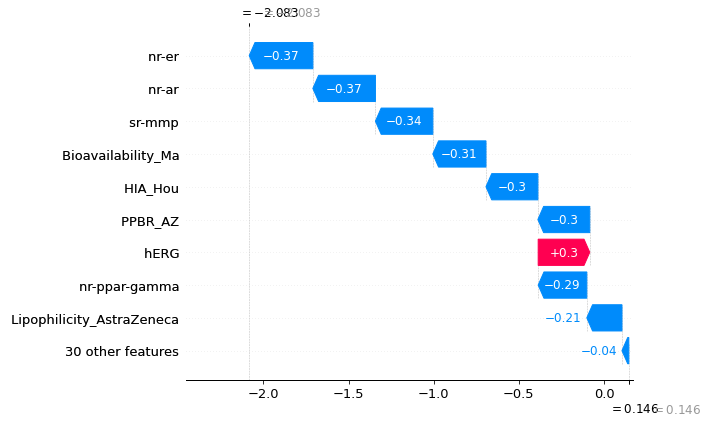

<Figure size 216x288 with 0 Axes>

In [191]:
shap_plot = shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[0].values,
    X_test.iloc[0]
)
ax = plt.gcf().set_size_inches((3, 4))

In [150]:
for bar in ax.patches:
    print(bar.get_width())

0.14079895615577698
-0.03406885266304016
-0.13293130695819855
-0.08487384021282196
-0.03467364236712456


## Višnja ADME

In [406]:
train = pd.read_csv('/home/dionizije/Documents/drug_attrition_oracle/data/processing_pipeline/TDC_predictions/train_subtasks_predictions.csv', index_col=0)
test = pd.read_csv('/home/dionizije/Documents/drug_attrition_oracle/data/processing_pipeline/TDC_predictions/test_subtasks_predictions.csv', index_col=0)

In [413]:
tox = pd.read_csv('/home/dionizije/Downloads/MasterDB_20Sep2021_ADMEPPredictor_Tox.csv', index_col=0)
adme_phys = pd.read_csv('/home/dionizije/Downloads/MasterDB_20Sep2021_ADMEPPredictor_PhysChem.csv', index_col=0)
rdkit = pd.read_csv("/home/dionizije/Documents/drug_attrition_oracle/data/processing_pipeline/descriptors/rdkit_descriptors.csv")
japtox = pd.read_csv("/home/dionizije/Documents/drug_attrition_oracle/data/processing_pipeline/descriptors/ADME-JapTox-RDKIT.csv").iloc[:, :34]
toxprint = pd.read_csv("/home/dionizije/Documents/drug_attrition_oracle/data/processing_pipeline/descriptors/toxprint_descriptors.csv")

In [414]:
toxprint_list = ["chain:alkaneBranch_neopentyl_C5",
    "bond:C(=O)N_carbamate_thio_generic",
    "chain:aromaticAlkene_Ph-C4_phenylbutadiene",
    "chain:aromaticAlkane_Ph-C1_acyclic_generic",
    "ring:aromatic_benzene",
    "bond:COH_alcohol_aliphatic_generic",
    "bond:COH_alcohol_sec-alkyl",
    "ring:aromatic_phenyl",
    "bond:C(=O)N_carboxamide_(NHR)",
    "group:aminoAcid_aminoAcid_generic",
    "chain:aromaticAlkane_Ph-C1-Ph",
    "bond:C=O_carbonyl_ab-unsaturated_generic",
    "chain:alkaneCyclic_ethyl_C2_(connect_noZ)",
    "bond:CC(=O)C_ketone_aliphatic_acyclic",
    "chain:aromaticAlkane_Ar-C-Ar",
    "bond:CC(=O)C_ketone_generic",
    "chembl_id"]
toxprint = toxprint[toxprint_list]

In [415]:
toxprint

,chain:alkaneBranch_neopentyl_C5,bond:C(=O)N_carbamate_thio_generic,chain:aromaticAlkene_Ph-C4_phenylbutadiene,chain:aromaticAlkane_Ph-C1_acyclic_generic,ring:aromatic_benzene,bond:COH_alcohol_aliphatic_generic,bond:COH_alcohol_sec-alkyl,ring:aromatic_phenyl,bond:C(=O)N_carboxamide_(NHR),group:aminoAcid_aminoAcid_generic,chain:aromaticAlkane_Ph-C1-Ph,bond:C=O_carbonyl_ab-unsaturated_generic,chain:alkaneCyclic_ethyl_C2_(connect_noZ),bond:CC(=O)C_ketone_aliphatic_acyclic,chain:aromaticAlkane_Ar-C-Ar,bond:CC(=O)C_ketone_generic,chembl_id
0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,CHEMBL1091250
1,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,CHEMBL1601
2,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,CHEMBL2110774
3,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,CHEMBL385517
4,0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,CHEMBL1201779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2498,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,CHEMBL918
2499,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,CHEMBL926
2500,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,CHEMBL370252
2501,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,CHEMBL1201336


In [398]:
japtox = japtox.dropna()

In [344]:
tox = tox.drop(columns=['test_train', 'drugbank_id', 'mw_ap', 'drugbank_three_class', 'sum', 'wd_consensus_1', 'wd_consensus_2', 'wd_consensus_3',
                       'wd_consensus_1_NO_DISCONT', 'wd_consensus_2_NO_DISCONT', 'wd_consensus_3_NO_DISCONT'])
adme_phys = adme_phys.drop(columns=['test_train', 'mw_ap', 'drugbank_three_class', 'sum', 'wd_consensus_1', 'wd_consensus_2', 'wd_consensus_3',
                       'wd_consensus_1_NO_DISCONT', 'wd_consensus_2_NO_DISCONT', 'wd_consensus_3_NO_DISCONT'])

In [407]:
train = train[['predict_withdrawn', 'chembl_id', 'wd_consensus_1']]
test = test[['predict_withdrawn', 'chembl_id', 'wd_consensus_1']]

In [345]:
train = train.merge(tox, how='inner', on='chembl_id')
train = train.merge(adme_phys, how='inner', on='chembl_id')
train = train.drop_duplicates('chembl_id')

In [363]:
train = train.merge(rdkit, how='inner', on='chembl_id')
test = test.merge(rdkit, how='inner', on='chembl_id')
train = train.drop_duplicates('chembl_id')
test = test.drop_duplicates('chembl_id')

In [346]:
test = test.merge(tox, how='inner', on='chembl_id')
test = test.merge(adme_phys, how='inner', on='chembl_id')
test = test.drop_duplicates('chembl_id')

In [399]:
train = train.merge(japtox, how='inner', on='chembl_id')
test = test.merge(japtox, how='inner', on='chembl_id')
train = train.drop_duplicates('chembl_id')
test = test.drop_duplicates('chembl_id')

In [416]:
train = train.merge(toxprint, how='inner', on='chembl_id')
test = test.merge(toxprint, how='inner', on='chembl_id')
train = train.drop_duplicates('chembl_id')
test = test.drop_duplicates('chembl_id')

In [418]:
y_train = train['wd_consensus_1']
y_test = test['wd_consensus_1']

X_train = train.drop(columns=['wd_consensus_1', 'chembl_id', 'standardized_smiles'])
X_test = test.drop(columns=['wd_consensus_1', 'chembl_id', 'standardized_smiles'])

In [419]:
X_train.columns

Index(['CYP2C9_Substrate_CarbonMangels', 'CYP2D6_Substrate_CarbonMangels',
       'sr-are', 'CYP3A4_Veith', 'nr-er-lbd', 'nr-er', 'Solubility_AqSolDB',
       'sr-atad5', 'Caco2_Wang', 'CYP2D6_Veith', 'Skin Reaction', 'PPBR_AZ',
       'Pgp_Broccatelli', 'BBB_Martins', 'nr-ar-lbd', 'VDss_Lombardo',
       'CYP3A4_Substrate_CarbonMangels', 'Lipophilicity_AstraZeneca',
       'LD50_Zhu', 'hERG', 'Bioavailability_Ma', 'nr-ahr', 'DILI', 'nr-ar',
       'AMES', 'CYP2C19_Veith', 'ClinTox', 'Half_Life_Obach', 'sr-hse',
       'CYP2C9_Veith', 'CYP1A2_Veith', 'HIA_Hou', 'nr-ppar-gamma',
       'Clearance_Hepatocyte_AZ', 'Carcinogens_Languin', 'nr-aromatase',
       'sr-mmp', 'sr-p53', 'predict_withdrawn',
       'chain:alkaneBranch_neopentyl_C5', 'bond:C(=O)N_carbamate_thio_generic',
       'chain:aromaticAlkene_Ph-C4_phenylbutadiene',
       'chain:aromaticAlkane_Ph-C1_acyclic_generic', 'ring:aromatic_benzene',
       'bond:COH_alcohol_aliphatic_generic', 'bond:COH_alcohol_sec-alkyl',
       '

In [420]:
    params = {
        'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
        'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
        'min_child_weight': [1, 3, 5, 7],
        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
        'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
        'scale_pos_weight': [5, 10, 15, 20, 35],
        'n_estimators': [100, 200, 300, 400, 500],
    }

In [421]:
classifier = XGBClassifier()

In [423]:
rs_model = RandomizedSearchCV(classifier, param_distributions=params, n_iter=100, scoring='average_precision',
                              n_jobs=-1, cv=6, verbose=3)
rs_model.fit(X_train, y_train)

Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 28.1min finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:16:59] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=6,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           validate_parameters=None,
                                           verbosity=None),
                   n_iter=100, n_jobs=-1,
          

In [424]:
predictions = rs_model.best_estimator_.predict_proba(X_test)
test_pred_df = pd.DataFrame({'probabilities': predictions[:, 1],
                             withdrawn_col: y_test,
                             'predicted_class': rs_model.predict(X_test)})

In [425]:
results = table_metrics_trees(test_pred_df, withdrawn_col)

* Predicted + toxprint

In [426]:
results

,F1 score,AP withdrawn,AP approved,AUROC withdrawn,Balanced accuracy,Precision withdrawn,Recall withdrawn,Precision approved,Recall approved,True positives,True negatives,False positives,False negatives
0,0.417266,0.43451,0.785302,0.833953,0.756201,0.295918,0.707317,0.959596,0.805085,29,285,69,12


* Predicted + rdkit

In [408]:
results

,F1 score,AP withdrawn,AP approved,AUROC withdrawn,Balanced accuracy,Precision withdrawn,Recall withdrawn,Precision approved,Recall approved,True positives,True negatives,False positives,False negatives
0,0.470588,0.365484,0.79933,0.789996,0.710004,0.454545,0.487805,0.940171,0.932203,20,330,24,21


* Predicted

In [387]:
results

,F1 score,AP withdrawn,AP approved,AUROC withdrawn,Balanced accuracy,Precision withdrawn,Recall withdrawn,Precision approved,Recall approved,True positives,True negatives,False positives,False negatives
0,0.453782,0.381002,0.793424,0.818038,0.757234,0.346154,0.658537,0.955836,0.855932,27,303,51,14


* RDKIT + predicted

In [371]:
results

,F1 score,AP withdrawn,AP approved,AUROC withdrawn,Balanced accuracy,Precision withdrawn,Recall withdrawn,Precision approved,Recall approved,True positives,True negatives,False positives,False negatives
0,0.41791,0.467745,0.784435,0.828166,0.653783,0.538462,0.341463,0.926829,0.966102,14,342,12,27


* adme + predicted

In [356]:
results

,F1 score,AP withdrawn,AP approved,AUROC withdrawn,Balanced accuracy,Precision withdrawn,Recall withdrawn,Precision approved,Recall approved,True positives,True negatives,False positives,False negatives
0,0.414414,0.403796,0.789654,0.834711,0.714104,0.328571,0.560976,0.944615,0.867232,23,307,47,18


* tox only

In [319]:
results

,F1 score,AP withdrawn,AP approved,AUROC withdrawn,Balanced accuracy,Precision withdrawn,Recall withdrawn,Precision approved,Recall approved,True positives,True negatives,False positives,False negatives
0,0.266667,0.349915,0.798773,0.808185,0.582024,0.421053,0.195122,0.912234,0.968927,8,343,11,33


* Results tox + physchem

In [303]:
results

,F1 score,AP withdrawn,AP approved,AUROC withdrawn,Balanced accuracy,Precision withdrawn,Recall withdrawn,Precision approved,Recall approved,True positives,True negatives,False positives,False negatives
0,0.384,0.369677,0.793242,0.834849,0.707937,0.285714,0.585366,0.945338,0.830508,24,294,60,17


## ATC codes one-hot encoded

In [431]:
train = pd.read_csv(root / 'data/processing_pipeline/TDC_predictions/train_subtasks_predictions.csv', index_col=0)
train = train.sample(frac=1, random_state=0)  # shuffle
test = pd.read_csv(root / 'data/processing_pipeline/TDC_predictions/test_subtasks_predictions.csv', index_col=0)

In [432]:
master_atc = pd.read_csv(root / 'data/processing_pipeline/master_atc.csv', index_col=0)

In [433]:
train = train.merge(master_atc, how='inner', on='chembl_id')
test = test.merge(master_atc, how='inner', on='chembl_id')

In [434]:
train['atc_code'] = train['atc_code'].str.split('0').str[0]
train['atc_code'] = train['atc_code'].str.split('1').str[0]

test['atc_code'] = test['atc_code'].str.split('0').str[0]
test['atc_code'] = test['atc_code'].str.split('1').str[0]

In [454]:
train['atc_code'].nunique()

14

In [435]:
y_train = train['wd_consensus_1']
y_test = test['wd_consensus_1']
X_train = train.drop(columns=['wd_consensus_1', 'chembl_id','standardized_smiles'])
X_test = test.drop(columns=['wd_consensus_1', 'chembl_id','standardized_smiles'])

In [436]:
X_train = pd.get_dummies(X_train)

In [437]:
X_test = pd.get_dummies(X_test)

In [440]:
    params = {
        'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
        'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
        'min_child_weight': [1, 3, 5, 7],
        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
        'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
        'scale_pos_weight': [5, 10, 15, 20, 35],
        'n_estimators': [100, 200, 300, 400, 500],
    }

In [441]:
classifier = XGBClassifier()

In [446]:
rs_model = RandomizedSearchCV(classifier, param_distributions=params, n_iter=100, scoring='average_precision',
                              n_jobs=-1, cv=6, verbose=3)
rs_model.fit(X_train, y_train)

Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 20.0min finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[00:15:56] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=6,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           validate_parameters=None,
                                           verbosity=None),
                   n_iter=100, n_jobs=-1,
          

In [450]:
predictions = rs_model.best_estimator_.predict_proba(X_test)
test_pred_df = pd.DataFrame({'probabilities': predictions[:, 1],
                             withdrawn_col: y_test,
                             'predicted_class': rs_model.predict(X_test)})

In [451]:
results = table_metrics_trees(test_pred_df, withdrawn_col)

In [452]:
results

,F1 score,AP withdrawn,AP approved,AUROC withdrawn,Balanced accuracy,Precision withdrawn,Recall withdrawn,Precision approved,Recall approved,True positives,True negatives,False positives,False negatives
0,0.378947,0.295174,0.816961,0.797965,0.668112,0.339623,0.428571,0.934783,0.907652,18,344,35,24


# WD Models with ATC codes

In [47]:
import pandas as pd
from pathlib import Path

In [7]:
root = Path('/home/dionizije/Documents/drug_attrition_oracle')

In [9]:
train = pd.read_csv(root / 'data/processing_pipeline/TDC_predictions/train_subtasks_predictions.csv', index_col=0)
train = train.sample(frac=1, random_state=0)  # shuffle
test = pd.read_csv(root / 'data/processing_pipeline/TDC_predictions/test_subtasks_predictions.csv', index_col=0)
#toxprints = pd.read_csv(root / 'data/processing_pipeline/descriptors/toxprint_descriptors.csv')
#toxprints_disease = pd.read_csv(root / 'complementary_model_results/toxprint_disease.csv')
#chembl_ids = toxprints['chembl_id']
#toxprints = toxprints[toxprint_descriptors_10pct] # drop mostly 0 zescriptors
#toxprints['chembl_id'] = chembl_ids
master_atc = pd.read_csv(root / 'data/processing_pipeline/master_atc.csv', index_col=0)

In [353]:
toxprints_disease = toxprints_disease.rename(columns={'Unnamed: 0': 'atc_code'})

In [354]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
toxprints.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in
          toxprints.columns.values]

In [10]:
train = train.merge(master_atc, how='inner', on='chembl_id')
test = test.merge(master_atc, how='inner', on='chembl_id')

#train = train.merge(toxprints, how='inner', on='chembl_id')
#test = test.merge(toxprints, how='inner', on='chembl_id')

In [14]:
train.to_csv('train_atc.csv')

In [13]:
test.to_csv('test_atc.csv')

In [356]:
    train['atc_code'] = train['atc_code'].str.split('0').str[0]
    train['atc_code'] = train['atc_code'].str.split('1').str[0]

    test['atc_code'] = test['atc_code'].str.split('0').str[0]
    test['atc_code'] = test['atc_code'].str.split('1').str[0]

In [404]:
results_df = pd.DataFrame(results, columns=columns[0], index=atc_codes)

In [405]:
results_df

,F1 score,AP withdrawn,AP approved,AUROC withdrawn,Balanced accuracy,Precision withdrawn,Recall withdrawn,Precision approved,Recall approved,True positives,True negatives,False positives,False negatives
C,0.000000,0.100442,0.947093,0.323077,0.435897,0.000000,0.000000,0.871795,0.871795,0.0,34.0,5.0,5.0
N,0.250000,0.216837,0.807135,0.503711,0.534323,0.230769,0.272727,0.829787,0.795918,3.0,39.0,10.0,8.0
M,0.400000,0.241667,0.901923,0.333333,0.550000,0.250000,1.000000,1.000000,0.100000,3.0,1.0,9.0,0.0
G,0.000000,0.050000,0.965789,0.342105,0.500000,0.000000,0.000000,0.950000,1.000000,0.0,19.0,0.0,1.0
L,0.000000,0.022222,0.993939,0.136364,0.420455,0.000000,0.000000,0.973684,0.840909,0.0,37.0,7.0,1.0
A,0.222222,0.222222,0.877779,0.677083,0.625000,0.142857,0.500000,0.947368,0.750000,1.0,18.0,6.0,1.0
D,0.000000,0.062745,0.950420,0.410714,0.428571,0.000000,0.000000,0.923077,0.857143,0.0,24.0,4.0,2.0
S,0.181818,0.250000,0.900207,0.934783,0.804348,0.100000,1.000000,1.000000,0.608696,1.0,14.0,9.0,0.0
J,0.000000,0.166667,0.943082,0.779070,0.430233,0.000000,0.000000,0.948718,0.860465,0.0,37.0,6.0,2.0
R,0.571429,0.513095,0.747381,0.887500,0.725000,0.666667,0.500000,0.904762,0.950000,2.0,19.0,1.0,2.0


In [403]:
results = []
atc_codes = []
columns = []
for i in list(train['atc_code'].unique()):
    print(i)
    train_subset = train.loc[train['atc_code'] == i]
    test_subset = test.loc[test['atc_code'] == i]

    train_subset = train_subset.drop_duplicates(subset=['chembl_id', 'atc_code'])
    test_subset = test_subset.drop_duplicates(subset=['chembl_id', 'atc_code'])

    #additional descriptors
    try:
        dis_tox = list(toxprints_disease.loc[toxprints_disease['atc_code'] == i][["0", "1", "2", "3", "4", "5","6", "7", "8", "9"]].values[0])
        toxprints_disease_cols = [col for col in toxprint.columns if col in dis_tox]
        toxprints_disease_cols.append('chembl_id')
        toxprints_disease_cols = toxprints[toxprints_disease_cols]

        train_subset = train_subset.merge(toxprints_disease_cols, how='inner', on='chembl_id')
        test_subset = test_subset.merge(toxprints_disease_cols, how='inner', on='chembl_id')

        train_subset = train_subset.drop_duplicates()
        test_subset = test_subset.drop_duplicates()

        y_train = train_subset['wd_consensus_1']
        y_test = test_subset['wd_consensus_1']
        X_train = train_subset.drop(columns=['wd_consensus_1', 'chembl_id', 'atc_code', 'standardized_smiles'])
        X_test = test_subset.drop(columns=['wd_consensus_1', 'chembl_id', 'atc_code', 'standardized_smiles'])
        
        classifier = XGBClassifier()
        rs_model = RandomizedSearchCV(classifier, param_distributions=params,
                                      n_iter=100, scoring='average_precision',
                                      n_jobs=-1, cv=6, verbose=3)
        rs_model.fit(X_train, y_train)

        predictions = rs_model.best_estimator_.predict_proba(X_test)
        test_pred_df = pd.DataFrame({'probabilities': predictions[:, 1],
                                     withdrawn_col: y_test,
                                     'predicted_class': rs_model.predict(X_test)})
        results.append(table_metrics_trees(test_pred_df, withdrawn_col).values[0])
        columns.append(table_metrics_trees(test_pred_df, withdrawn_col).columns)
        atc_codes.append(i)

    except:
        continue  

C
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   47.3s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:26:22] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
N
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   52.9s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:27:16] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
M
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   46.0s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:28:02] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
G
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   46.7s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


[12:28:49] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
L
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 448 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   37.7s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:29:27] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
V
A
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   51.8s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:30:20] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
D
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   48.8s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:31:09] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
H
S
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   30.6s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:31:40] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
J
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   29.6s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:32:10] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
R
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 585 out of 600 | elapsed:   27.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   28.3s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:32:38] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
B
P
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:   24.8s


[12:33:08] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   28.8s finished
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
invalid value encountered in true_divide


## Withdrawal reasons

In [127]:
import pandas as pd

In [128]:
master = pd.read_csv('/home/dionizije/Documents/drug_attrition_oracle/data/processing_pipeline/MasterDB_15Sep2021_standardized.csv', index_col=0)

In [129]:
withdrawn = pd.read_csv('/home/dionizije/Documents/drug_attrition_oracle/data/raw/withdrawn.csv')

In [130]:
withdrawn

,name,pubchem_cid,chembl_id,first withdrawal,countries,toxicity_type
0,Telaprevir,CID3010818,CHEMBL231813,2014.0,USA,toxic_dermis
1,Ribavirin,CID37542,CHEMBL1643,2014.0,USA;EU,toxic_respiratory
2,Ketoconazole,CID47576,CHEMBL295698,2013.0,EU;AUS,toxic_hepa
3,Tetrazepam,CID25215,CHEMBL2105527,2013.0,EU,toxic_dermis
4,Clorazepate,CID2809,CHEMBL1213252,2012.0,USA,toxic_systemic
...,...,...,...,...,...,...
246,Flurothyl,CID9528,CHEMBL477874,NaN,NaN,toxic_neuro
247,Fominoben,CID3407,CHEMBL1697837,NaN,NaN,toxic_teratogen
248,Benzydamine Hydrochloride,CID65464,CHEMBL1528134,NaN,NaN,toxic_opthalmic
249,Iodamide,CID3723,CHEMBL1201239,NaN,USA,toxic_neuro


In [131]:
master = master.merge(withdrawn[['chembl_id', 'toxicity_type']], how='left')

In [132]:
master['toxicity_type'] = master['toxicity_type'].fillna('None')

In [133]:
master['toxicity_type'] = master['toxicity_type'].str.split(', ')
#master['toxicity_type'] = master['toxicity_type'].str.split(';')

In [134]:
master = master.explode('toxicity_type')

In [135]:
master['toxicity_type'].value_counts()

None                            2277
toxic_hepa                        53
toxic_cardio                      42
toxic_hema                        24
toxic_neuro                       22
toxic_dermis                      22
toxic_systemic                    20
toxic_carcinogenic                19
toxic_nephro                       9
toxic_respiratory                  9
toxic_teratogen                    8
toxic_gastro                       4
toxic_muscoskelet                  4
toxic_opthalmic                    3
toxic_systemic; toxic_dermis       1
toxic_systemic; toxic_gastro       1
toxic_hema; toxic_systemic         1
Name: toxicity_type, dtype: int64

In [136]:
master['toxicity_type'] = master['toxicity_type'].str.split('; ')

In [137]:
master = master.explode('toxicity_type')

In [138]:
master['toxicity_type'].value_counts()

None                  2277
toxic_hepa              53
toxic_cardio            42
toxic_hema              25
toxic_systemic          23
toxic_dermis            23
toxic_neuro             22
toxic_carcinogenic      19
toxic_nephro             9
toxic_respiratory        9
toxic_teratogen          8
toxic_gastro             5
toxic_muscoskelet        4
toxic_opthalmic          3
Name: toxicity_type, dtype: int64

In [139]:
other_tox = ['toxic_nephro', 'toxic_respiratory', 'toxic_teratogen', 'toxic_gastro', 'toxic_muscoskelet', 'toxic_opthalmic']

In [140]:
master.loc[master['toxicity_type'].isin(other_tox), 'toxicity_type'] = 'Other'

In [141]:
master['toxicity_type'].value_counts()

None                  2277
toxic_hepa              53
toxic_cardio            42
Other                   38
toxic_hema              25
toxic_systemic          23
toxic_dermis            23
toxic_neuro             22
toxic_carcinogenic      19
Name: toxicity_type, dtype: int64

In [142]:
from sklearn.preprocessing import LabelBinarizer

In [143]:
binarizer = LabelBinarizer()
binarizer.fit(master['toxicity_type'])

LabelBinarizer()

In [144]:
labels = binarizer.transform(master['toxicity_type'])

In [146]:
for i in range(0, 9):
    master['tox_{}'.format(i)] = labels[:, i]

In [148]:
labels

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [147]:
master

,chembl_id,drugbank_id,canonical_smiles_ap,canonical_smiles_ap_nonstereo,orginal_smiles,mw_ap,rule_of_5,rule_of_5_label,in_drugbank,in_chembl,...,toxicity_type,tox_0,tox_1,tox_2,tox_3,tox_4,tox_5,tox_6,tox_7,tox_8
0,CHEMBL2111100,DB13615,C(=O)(O[C@H](COC(=O)CCCCCCCCCCCCCCC)COP(=O)(OC...,C(=O)(OC(COC(=O)CCCCCCCCCCCCCCC)COP(=O)(OCCNC(...,CCCCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)(O)OCCNC(=O...,1237.52623,3,Hb; Mw; NO,yes,yes,...,None,1,0,0,0,0,0,0,0,0
1,CHEMBL41355,DB04953,C(=O)(OCC)Nc1c(cc(NCc2ccc(F)cc2)cc1)N,C(=O)(OCC)Nc1c(cc(NCc2ccc(F)cc2)cc1)N,CCOC(=O)Nc1ccc(NCc2ccc(F)cc2)cc1N,303.33836,0,NaN,yes,yes,...,None,1,0,0,0,0,0,0,0,0
2,CHEMBL409153,DB11633,C(#N)c1ccc(-c2nc(sc2)[C@@H]([C@](c3c(F)ccc(F)c...,C(#N)c1ccc(-c2nc(sc2)C(C(c3c(F)ccc(F)c3)(O)Cn4...,C[C@@H](c1nc(-c2ccc(C#N)cc2)cs1)[C@](O)(Cn1cnc...,437.47339,0,NaN,yes,yes,...,None,1,0,0,0,0,0,0,0,0
3,CHEMBL4094358,DB12434,C(=O)([C@]1([C@@H]2[C@]([C@H]3[C@@]4(CC([C@@](...,C(=O)(C1(C2C(C3C4(CC(C(OC5OC(C(O)C(O)C5OC6OC(C...,C[C@@]12CCC[C@](C)([C@H]1CC[C@@]13CC(=C)[C@@](...,642.74590,3,Hb; Mw; NO,yes,yes,...,None,1,0,0,0,0,0,0,0,0
4,CHEMBL41,DB00472,C(F)(F)(F)c1ccc(OC(c2ccccc2)CCNC)cc1,C(F)(F)(F)c1ccc(OC(c2ccccc2)CCNC)cc1,CNCCC(Oc1ccc(C(F)(F)F)cc1)c1ccccc1,309.33346,1,LP,yes,yes,...,None,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2498,CHEMBL544,DB09516,O(c1ccc(O)cc1)C,O(c1ccc(O)cc1)C,COc1ccc(O)cc1,124.14026,0,NaN,yes,yes,...,None,1,0,0,0,0,0,0,0,0
2499,CHEMBL546,DB01580,O(c1c(OCC(O)CNC(C)C)cccc1)CC=C,O(c1c(OCC(O)CNC(C)C)cccc1)CC=C,C=CCOc1ccccc1OCC(O)CNC(C)C,265.35471,0,NaN,yes,yes,...,None,1,0,0,0,0,0,0,0,0
2500,CHEMBL549,DB00215,C(#N)c1cc2c(C(c3ccc(F)cc3)(OC2)CCCN(C)C)cc1,C(#N)c1cc2c(C(c3ccc(F)cc3)(OC2)CCCN(C)C)cc1,CN(C)CCCC1(c2ccc(F)cc2)OCc2cc(C#N)ccc21,324.40057,0,NaN,yes,yes,...,None,1,0,0,0,0,0,0,0,0
2501,CHEMBL550,DB01085,O=C1OC[C@@H]([C@@H]1CC)Cc2n(cnc2)C,O=C1OCC(C1CC)Cc2n(cnc2)C,CC[C@@H]1C(=O)OC[C@@H]1Cc1cncn1C,208.26182,0,NaN,yes,yes,...,None,1,0,0,0,0,0,0,0,0


In [158]:
binarizer.inverse_transform(np.array(master.iloc[0].iloc[-9:].values))

NameError: name 'np' is not defined